# CONTENT BASED MODELS

Imagine, we have a service (like Youtbe, Netflix or whatever) and we have some new users. We want to recommend our users something they would like, but those users are new, so we know nothing about them. How to build recommender system in such situation? Another question is how to score and recommend new items with known features but without known ratings. 

The answer is simple: we have items (videos, movies, ect). Each item has some features and each item has its own rating (calculated based on the grades users or critics put). We want to recommend items with higher rating to our newbies. Below there are three ways how to do that.

But firstly, let me show the datsets we are going to work with.

Download the preprocessed dataset [here](https://drive.google.com/drive/folders/1YPqWaZYW2axz91YKkaM7j_xPqF5rSVx2?usp=drive_link).

In [41]:
import os
import ast
import numpy as np
import pandas as pd
from scipy.sparse import diags
from scipy.sparse.linalg import norm as sparse_norm

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline, TransformerMixin
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import shap

## Dataset

### Reviews


Lets have a look on our *reviews* dataset. In this dataset we need only four columns with titles *user_id*, *anime_id*, *favorites_anime* and *score*.

- ***user_id*** User profile name. Some profile names are literally insane =)

- ***anime_id*** The mapping of anime titles column onto integers.

- ***score*** grade, how the user with the specific *user_id* evaluated the anime with specific *anime_id*.

-  ***favorites_anime*** List of animes the user with the specific *user_id*  considered as his favourites. **ATTENTION** the animes from this list may not occur in user history (animes user graded). User may have mentioned some animes as favourites, but did not graded them. Automatically, we will consider that the score of favorite animes is **10**



In [3]:
USER_COL = "user_id"
ITEM_COL = "anime_id"
RELEVANCE_COL = "score"

In [4]:
base_path = "./anime_data"

In [5]:
review_data = pd.read_csv(os.path.join(base_path, 'reviews.gz'))

In [6]:
review_data.head()

,uid,user_id,anime_id,text,score,scores,link
0,255938,DesolatePsyche,34096,"First things first. My ""reviews"" system is exp...",8,"{'Overall': '8', 'Story': '8', 'Animation': '8...",https://myanimelist.net/reviews.php?id=255938
1,259117,baekbeans,34599,Let me start off by saying that Made in Abyss ...,10,"{'Overall': '10', 'Story': '10', 'Animation': ...",https://myanimelist.net/reviews.php?id=259117
2,253664,skrn,28891,"Art 9/10: It is great, especially the actions ...",7,"{'Overall': '7', 'Story': '7', 'Animation': '9...",https://myanimelist.net/reviews.php?id=253664
3,8254,edgewalker00,2904,Story \r\ntaking place 1 yr from where season ...,9,"{'Overall': '9', 'Story': '9', 'Animation': '9...",https://myanimelist.net/reviews.php?id=8254
4,291149,aManOfCulture99,4181,Kyoto Animations greatest strength is being ab...,10,"{'Overall': '10', 'Story': '10', 'Animation': ...",https://myanimelist.net/reviews.php?id=291149


In [7]:
def get_log_info(log, user_id='user_id', item_id='item_id'):
    print(f'Num reviews = {log.shape[0]},\nnum users = {log[user_id].nunique()},\nnum items = {log[item_id].nunique()}')

In [8]:
get_log_info(review_data, user_id=USER_COL, item_id=ITEM_COL)

Num reviews = 109297,
num users = 37458,
num items = 7636


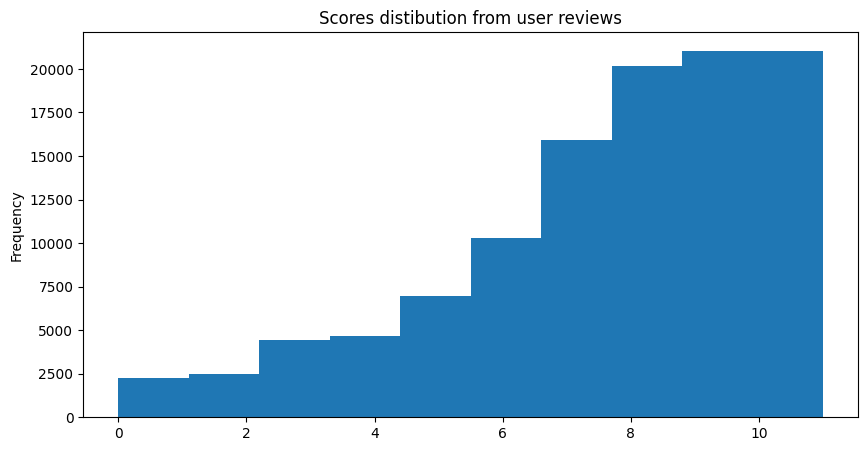

In [9]:
review_data[RELEVANCE_COL].plot.hist(bins=10, figsize=(10, 5), title='Scores distibution from user reviews');

#### How does the distribution of ratings change if we have, for example, a marketplace data?

In [10]:
def group_by_and_plot(df, group_by_name, rating_col_name, quantile=0.99, title=''):
    grouped = df.groupby(group_by_name)[rating_col_name].count()
    print(grouped.describe(percentiles=[0.05, .25, .5, .75, 0.95]))
    grouped[grouped < grouped.quantile(quantile)].plot(kind='hist', bins=20, figsize=(10, 5), title=title)
    return grouped

count    37458.000000
mean         2.917855
std          7.985410
min          1.000000
5%           1.000000
25%          1.000000
50%          1.000000
75%          3.000000
95%          9.000000
max        537.000000
Name: score, dtype: float64


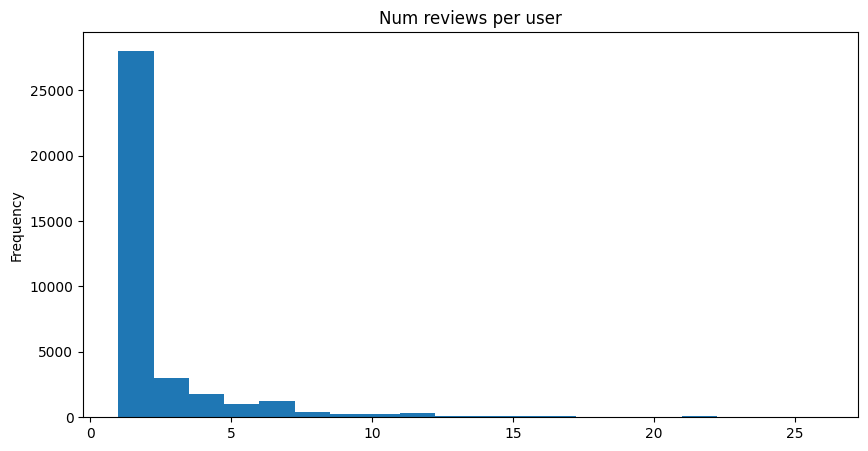

In [11]:
group_by_and_plot(review_data, group_by_name=USER_COL, rating_col_name=RELEVANCE_COL, quantile=0.99, title='Num reviews per user');

count    7636.000000
mean       14.313384
std        39.704994
min         1.000000
5%          1.000000
25%         1.000000
50%         3.000000
75%        11.000000
95%        59.000000
max      1080.000000
Name: score, dtype: float64


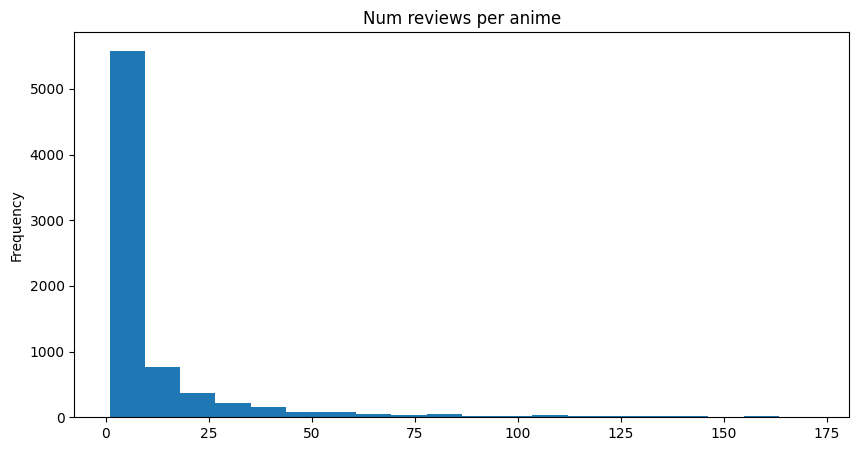

In [12]:
group_by_and_plot(review_data, group_by_name=ITEM_COL, rating_col_name=RELEVANCE_COL, quantile=0.99, title='Num reviews per anime');

#### How many animes could we reliably recommend using popularity-based methods? 

### Animes


The main columns for us are:

- ***anime_id*** - the same id we have in the table above.

- ***synopsis*** - the description of the anime with a specific **anime_id**

- ***score*** - average score over all the grades users or critics  put to the corresponding anime


In [13]:
anime_data = pd.read_csv(os.path.join(base_path, 'animes.gz'), na_filter=False)

In [14]:
anime_data.head(1).T

,0
anime_id,1
title,Cowboy Bebop
synopsis,"In the year 2071, humanity has colonized sever..."
genre,"Action, Adventure, Comedy, Drama, Sci-Fi, Space"
aired,"Apr 3, 1998 to Apr 24, 1999"
episodes,26
members,930311
popularity,39
ranked,26.0
score,8.81


In [15]:
anime_data['genre'].str.strip().str.split(", ").explode().value_counts()

genre
Comedy           5640
Action           3572
Fantasy          2971
Adventure        2753
Sci-Fi           2462
Kids             2458
Drama            2457
Shounen          1915
Music            1863
Romance          1762
Slice of Life    1744
School           1567
Supernatural     1358
Hentai           1295
Mecha            1060
Historical       1051
Magic            1013
Seinen            805
Ecchi             740
Sports            679
Mystery           674
Shoujo            668
Parody            619
Super Power       600
Military          541
Space             475
Demons            453
Horror            434
Dementia          402
Harem             374
Martial Arts      367
Game              348
Psychological     322
Police            239
Samurai           199
Vampire           135
Thriller          120
Cars              117
Josei              93
Shounen Ai         91
                   75
Shoujo Ai          73
Yuri               40
Yaoi               40
Name: count, dtype: int64

In [16]:
anime_data.shape # 7636 in reviews, the rest won't be covered by the popularity-based models

(16216, 12)

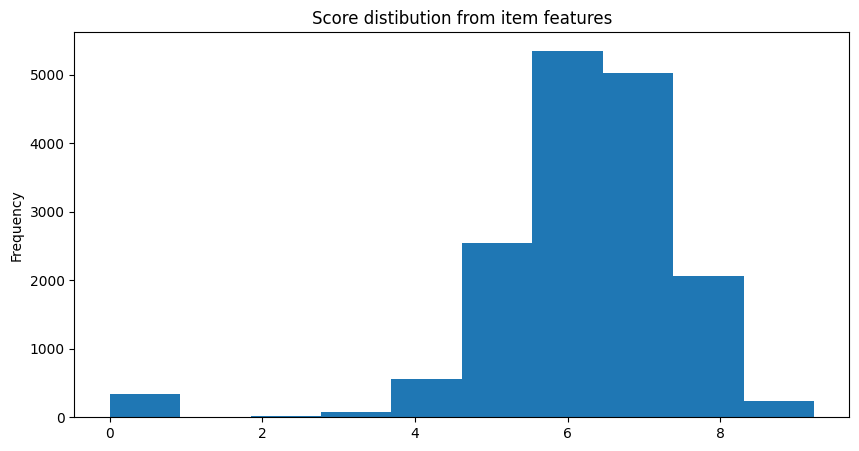

In [17]:
anime_data[RELEVANCE_COL].plot.hist(bins=10, title='Score distibution from item features', figsize=(10, 5));

In [18]:
(anime_data[RELEVANCE_COL] > 0).sum()

15875

In [19]:
all_anime_data = (
    anime_data[['anime_id', 'score']]
    .assign(tokens=anime_data[['title', 'genre', 'synopsis']].apply('; '.join, axis=1))
    .set_index('anime_id')
    # ['tokens']
)

In [20]:
all_anime_data.head()

,score,tokens
anime_id,,
1,8.81,"Cowboy Bebop; Action, Adventure, Comedy, Drama..."
5,8.40,"Cowboy Bebop: Tengoku no Tobira; Action, Drama..."
6,8.28,"Trigun; Action, Sci-Fi, Adventure, Comedy, Dra..."
7,7.32,"Witch Hunter Robin; Action, Magic, Police, Sup..."
8,7.02,"Bouken Ou Beet; Adventure, Fantasy, Shounen, S..."


#### What can we do with these tokens?

### User profiles

This dataset contains additional information about users, including their favorite anime.

- ***user_id*** - the same user id as in the reviews table.

- ***gender*** - user gender

- ***birthday*** - user birthday

- ***favorites_anime*** - a list of user favorites


In [21]:
profile_data = pd.read_csv(os.path.join(base_path, 'profiles.gz'), converters={'favorites_anime': ast.literal_eval})

In [22]:
profile_data.head()

,user_id,gender,birthday,favorites_anime,link
0,DesolatePsyche,Male,"Oct 2, 1994","[226, 235, 269, 457, 1482, 1698, 2904, 4981, 5...",https://myanimelist.net/profile/DesolatePsyche
1,baekbeans,Female,"Nov 10, 2000","[853, 918, 3588, 6956, 9253, 11061, 13601, 205...",https://myanimelist.net/profile/baekbeans
2,skrn,NaN,NaN,"[512, 918, 1943, 2904, 9989, 11741, 17074, 232...",https://myanimelist.net/profile/skrn
3,edgewalker00,Male,Sep 5,"[849, 2904, 3588, 5680, 37349]",https://myanimelist.net/profile/edgewalker00
4,aManOfCulture99,Male,"Oct 30, 1999","[235, 849, 2167, 4181, 4382, 5680, 7791, 9617,...",https://myanimelist.net/profile/aManOfCulture99


In [23]:
profile_data.shape

(37458, 5)

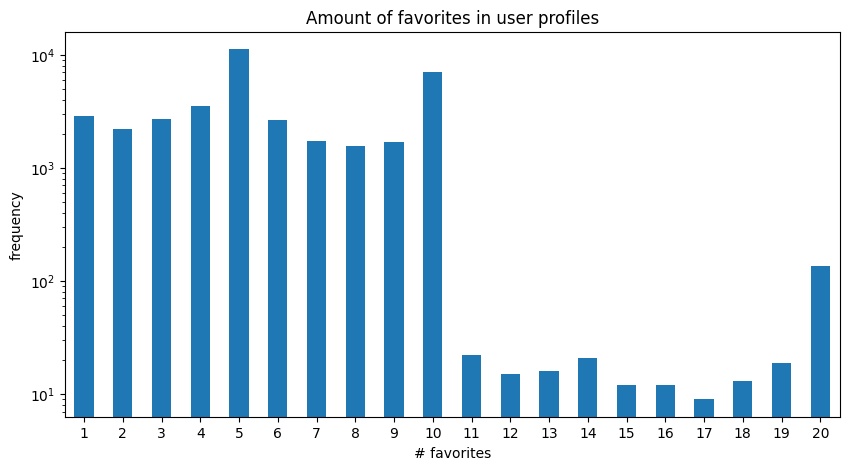

In [24]:
(
    profile_data['favorites_anime']
    .apply(len)
    .value_counts(sort=False).sort_index()#.cumsum()
    .plot.bar(
        logy=True,
        rot=0,
        xlabel='# favorites',
        ylabel='frequency',
        title='Amount of favorites in user profiles',
        figsize=(10, 5)
    )
);

### Favorites ratings

In [25]:
favorites_data = profile_data.set_index('user_id')['favorites_anime']
favorites_scores = pd.merge(
    favorites_data.explode().rename('anime_id').reset_index(),
    review_data[['user_id', 'anime_id', 'score']],
    on = ['user_id', 'anime_id'],
    how = 'left'
)['score']

print(f'Fraction of favorites without the rating: {favorites_scores.isnull().mean():.0%}')

Fraction of favorites without the rating: 93%


- Most of the favorites do not have ratings info.
- For the sake of evaluation in this excercise, we will make two assumptions:
  - favorites are of the highest interest to users,
  - other animes that users rate highly should be somewhat similar to their favorites.

# Data split


- In order to construct test set we use the users who have some anime in their favourites list.
- For these users we take **n_pairs** animes a user liked and **n_pairs** animes the user disliked from their anime reviews.
  - We assume the user liked anime if he put the grade no less than some *score_cutoff* value.
- The quality of predictions is then evaluated by comparing how close the liked animes to the favorites based on the predicted scores.

In [26]:
def get_test_pairs(reviews, favorites, n_pairs, score_cutoff, seed):
    '''
    Construct a dataset consisting of pairs of liked and disliked animes. The likes and dislikes
    are defined by the ratings value: everything below threshold is a dislike, the rest are likes.
        
    The function ensures that the amount of likes and dislikes is the same per each user in data.
    The users that do not contain enough likes or dislikes are discarded from the result.
    The result is to be used for evaluating the quality of recommendations by some algorithms.
    Hence, user favorites are excluded to ensure that there is no trivial solution.
    '''
    rng = np.random.default_rng(seed)
    def strict_sample_no_favs(series):
        # sample `n_pairs` elements from `series`, if not enough data - return empty list,
        # discard favorites, otherwise the evaluation on test pairs against favorites makes no sense
        above_cutoff, user_id = series.name
        allowed_items = np.setdiff1d(series.values, favorites.loc[user_id])
        return rng.choice(allowed_items, n_pairs, replace=False) if len(allowed_items)>=n_pairs else []
    
    test_pairs = (
        reviews
         # split by likes and dislikes, group by users
        .groupby([(reviews["score"] >= score_cutoff), 'user_id'])
        # sample `n_pairs` items (both likes and dislikes), disregard user favorites
        ['anime_id'].apply(strict_sample_no_favs)
         # disregard users that have not enough items
        .loc[lambda x: x.apply(len) > 0]
         # make two columns of likes and dislikes
        .unstack('score')
        # ensure each user has both likes and dislikes
        .dropna()
         # rename by rule `score >= score_cutoff`
        .rename(columns={False: 'dislikes', True: 'likes'})
    )
    return test_pairs

We will generate the training data by excluding animes from the pairs of likes and dislikes contained in the test data. 

In [27]:
def split_anime_train_test_data(reviews, favorites, anime, *, n_pairs=3, score_cutoff=5, seed=0):
    '''
    Function to construct train dataset. It deletes animes that occured in the test set
    to prevent information leakage from test to train.
    '''
    test_data = get_test_pairs(reviews, favorites, n_pairs, score_cutoff, seed)
    test_anime_set = (
        test_data
        .melt(value_name='animes') # reshape 2 columns into signle column
        ['animes'].explode() # flatten all lists into a single long 1d array
        .unique() # get only unique values
    )
    train_data = (
        anime
        # only use known score - to be used as the prediction target,
        # also prevent test data leaks into training
        .query('score > 0 and anime_id not in @test_anime_set')
        # combine several text fields into a unified feature view
        .assign(tokens = lambda x: x[['title', 'genre', 'synopsis']].apply('; '.join, axis=1))
        # only take necessary fields
        .loc[:, ['anime_id', 'tokens', 'score']]
    )
    return train_data, test_data

In [28]:
anime_train, anime_test = split_anime_train_test_data(
    review_data, favorites_data, anime_data, score_cutoff=5
)

In [29]:
anime_train.head()

,anime_id,tokens,score
1,5,"Cowboy Bebop: Tengoku no Tobira; Action, Drama...",8.40
4,8,"Bouken Ou Beet; Adventure, Fantasy, Shounen, S...",7.02
5,15,"Eyeshield 21; Action, Sports, Comedy, Shounen;...",8.02
7,17,"Hungry Heart: Wild Striker; Slice of Life, Com...",7.65
8,18,"Initial D Fourth Stage; Action, Cars, Sports, ...",8.18


In [30]:
# to evaluate classification/regression metrics

test_animes = (anime_test
        .melt(value_name='animes') # reshape 2 columns into signle column
        ['animes'].explode() # flatten all lists into a single long 1d array
        .unique()) # get only unique values

anime_test_animes = anime_data.query('score > 0 and anime_id in @test_animes') \
        .assign(tokens = lambda x: x[['title', 'genre', 'synopsis']].apply('; '.join, axis=1)) \
        .loc[:, ['anime_id', 'tokens', 'score']]

In [31]:
anime_data.query('score > 0').shape, anime_train.shape[0] + anime_test_animes.shape[0]

((15875, 12), 15875)

In [32]:
anime_test.head()

score,dislikes,likes
user_id,,
-Ereya-,"[6747, 169, 5525]","[12413, 15613, 9989]"
-HippySnob-,"[31245, 36516, 31804]","[16355, 39456, 37021]"
-Remix-,"[31043, 31914, 28171]","[29787, 15225, 11889]"
-Ryu,"[10620, 35849, 16762]","[36475, 401, 31904]"
0MAN0,"[17265, 226, 4382]","[15809, 10620, 849]"


In [33]:
anime_test_animes.head(2)

,anime_id,tokens,score
0,1,"Cowboy Bebop; Action, Adventure, Comedy, Drama...",8.81
2,6,"Trigun; Action, Sci-Fi, Adventure, Comedy, Dra...",8.28


In [34]:
anime_test.shape

(696, 2)

count    696.000000
mean      29.778736
std       43.207512
min        6.000000
5%         7.000000
25%       10.000000
50%       16.000000
75%       32.000000
95%       89.500000
max      537.000000
Name: anime_id, dtype: float64


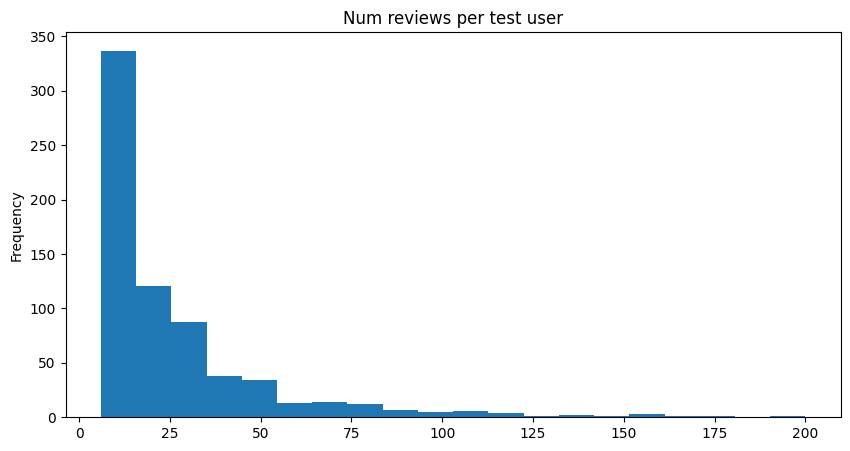

In [35]:
group_by_and_plot(review_data.query('user_id in @anime_test.index.values'), group_by_name=USER_COL, rating_col_name=ITEM_COL, quantile=0.99, title='Num reviews per test user');

You will need to build a personalized models for those users in your HW. Do you have enough data? 

In [36]:
favorites_data.head()

user_id
DesolatePsyche     [226, 235, 269, 457, 1482, 1698, 2904, 4981, 5...
baekbeans          [853, 918, 3588, 6956, 9253, 11061, 13601, 205...
skrn               [512, 918, 1943, 2904, 9989, 11741, 17074, 232...
edgewalker00                          [849, 2904, 3588, 5680, 37349]
aManOfCulture99    [235, 849, 2167, 4181, 4382, 5680, 7791, 9617,...
Name: favorites_anime, dtype: object